In [40]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv(r"C:\ML Project\AI_and_ML\GitHub\Jet_Engine_\Jet_Engine_Data_Set\train_FD001.txt", 
                 sep=r"\s+",  # split by whitespace
                 header=None) # no column names
csv_path='"C:\ML Project\AI_and_ML\GitHub\Jet_Engine_\Jet_Engine_Data_Set\Train_FD001.csv"'

nice_names = [
    'engine_id', 'cycle',
    'Altitude', 'Speed', 'Angle',                      # operational settings (context)
    'total_temp_at_fan_inlet',                         # s1  (T2)
    'total_temp_at_lpc_outlet',                        # s2  (T24)
    'total_temp_at_hpc_outlet',                        # s3  (T30)
    'total_temp_at_lpt_outlet',                        # s4  (T50)
    'pressure_at_fan_inlet',                           # s5  (P2)
    'total_pressure_in_bypass_duct',                   # s6  (P15)
    'total_pressure_at_hpc_outlet',                    # s7  (P30)
    'physical_fan_speed',                              # s8  (Nf)
    'physical_core_speed',                             # s9  (Nc)
    'engine_pressure_ratio',                           # s10 (EPR = P50/P2)
    'static_pressure_at_hpc_outlet',                   # s11 (Ps30)
    'ratio_of_fuel_flow_to_Ps30',                      # s12 (phi)
    'corrected_fan_speed',                             # s13 (NRf)
    'corrected_core_speed',                            # s14 (NRc)
    'bypass_ratio',                                    # s15 (BPR)
    'burner_fuel_air_ratio',                           # s16 (farB)
    'bleed_enthalpy',                                  # s17 (htBleed)
    'demanded_fan_speed',                              # s18 (Nf_dmd)
    'demanded_corrected_fan_speed',                    # s19 (PCNfR_dmd)
    'hpt_coolant_bleed',                               # s20 (W31)
    'lpt_coolant_bleed'                                # s21 (W32)
]

# If the file has fewer/more columns, trim or extend names safely
if df.shape[1] != len(nice_names):
    print(f"Warning: file has {df.shape[1]} columns, expected {len(nice_names)} for FD001.")
    print("Proceeding by assigning names up to the number of columns present.")
df.columns = nice_names[:df.shape[1]]

# ---------------------------------------
# 4) Compute Remaining Useful Life (RUL)
# ---------------------------------------
# For each engine_id, find its last cycle, then RUL = max_cycle - cycle
if 'engine_id' not in df.columns or 'cycle' not in df.columns:
    raise ValueError("Expected 'engine_id' and 'cycle' columns after renaming.")

rul_by_engine = df.groupby('engine_id')['cycle'].max().reset_index()
rul_by_engine.columns = ['engine_id', 'max_cycle']
df = df.merge(rul_by_engine, on='engine_id', how='left')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop(columns=['max_cycle'], inplace=True)

# --------------------------------------
# 5) Missing values (null) diagnostics
# --------------------------------------
total_nulls = df.isnull().sum().sum()
nulls_per_col = df.isnull().sum()

print("Total missing values in dataset:", int(total_nulls))
print("\nMissing values per column (only showing columns with nulls):")
print(nulls_per_col[nulls_per_col > 0])

# -----------------------------------
# 6) Save to CSV and quick preview
# -----------------------------------
print(f"\n✅ CSV saved to: {csv_path}\n")
print(df.head())

Total missing values in dataset: 0

Missing values per column (only showing columns with nulls):
Series([], dtype: int64)

✅ CSV saved to: "C:\ML Project\AI_and_ML\GitHub\Jet_Engine_\Jet_Engine_Data_Set\Train_FD001.csv"

   engine_id  cycle  Altitude   Speed  Angle  total_temp_at_fan_inlet  \
0          1      1   -0.0007 -0.0004  100.0                   518.67   
1          1      2    0.0019 -0.0003  100.0                   518.67   
2          1      3   -0.0043  0.0003  100.0                   518.67   
3          1      4    0.0007  0.0000  100.0                   518.67   
4          1      5   -0.0019 -0.0002  100.0                   518.67   

   total_temp_at_lpc_outlet  total_temp_at_hpc_outlet  \
0                    641.82                   1589.70   
1                    642.15                   1591.82   
2                    642.35                   1587.99   
3                    642.35                   1582.79   
4                    642.37                   1582.85  

In [9]:
df.head()

,engine_id,cycle,Altitude,Speed,Angle,total_temp_at_fan_inlet,total_temp_at_lpc_outlet,total_temp_at_hpc_outlet,total_temp_at_lpt_outlet,pressure_at_fan_inlet,...,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
df.isnull().sum()

engine_id                        0
cycle                            0
Altitude                         0
Speed                            0
Angle                            0
total_temp_at_fan_inlet          0
total_temp_at_lpc_outlet         0
total_temp_at_hpc_outlet         0
total_temp_at_lpt_outlet         0
pressure_at_fan_inlet            0
total_pressure_in_bypass_duct    0
total_pressure_at_hpc_outlet     0
physical_fan_speed               0
physical_core_speed              0
engine_pressure_ratio            0
static_pressure_at_hpc_outlet    0
ratio_of_fuel_flow_to_Ps30       0
corrected_fan_speed              0
corrected_core_speed             0
bypass_ratio                     0
burner_fuel_air_ratio            0
bleed_enthalpy                   0
demanded_fan_speed               0
demanded_corrected_fan_speed     0
hpt_coolant_bleed                0
lpt_coolant_bleed                0
RUL                              0
dtype: int64

In [10]:
x=df.drop(columns=['engine_id'])
x

,cycle,Altitude,Speed,Angle,total_temp_at_fan_inlet,total_temp_at_lpc_outlet,total_temp_at_hpc_outlet,total_temp_at_lpt_outlet,pressure_at_fan_inlet,total_pressure_in_bypass_duct,...,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed,RUL
0,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [13]:
# s=StandardScaler()
# df1 = pd.DataFrame(s.fit_transform(x), columns=x.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

df1.tail()

,cycle,Altitude,Speed,Angle,total_temp_at_fan_inlet,total_temp_at_lpc_outlet,total_temp_at_hpc_outlet,total_temp_at_lpt_outlet,pressure_at_fan_inlet,total_pressure_in_bypass_duct,...,corrected_fan_speed,corrected_core_speed,bypass_ratio,burner_fuel_air_ratio,bleed_enthalpy,demanded_fan_speed,demanded_corrected_fan_speed,hpt_coolant_bleed,lpt_coolant_bleed,RUL
20626,0.540166,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,1.0,...,0.558824,0.194344,0.656791,0.0,0.750000,0.0,0.0,0.271318,0.109500,0.01108
20627,0.542936,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,1.0,...,0.500000,0.188668,0.727203,0.0,0.583333,0.0,0.0,0.124031,0.366197,0.00831
20628,0.545706,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,1.0,...,0.529412,0.212148,0.922278,0.0,0.833333,0.0,0.0,0.232558,0.053991,0.00554
20629,0.548476,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,1.0,...,0.514706,0.203065,0.823394,0.0,0.583333,0.0,0.0,0.116279,0.234466,0.00277
20630,0.551247,0.316092,0.083333,0.0,0.0,0.795181,0.639634,0.842167,0.0,1.0,...,0.558824,0.192951,0.687572,0.0,0.666667,0.0,0.0,0.178295,0.218172,0.00000


In [14]:
f=df1.drop(columns='RUL')
y=df1['RUL']
y

0        0.529086
1        0.526316
2        0.523546
3        0.520776
4        0.518006
           ...   
20626    0.011080
20627    0.008310
20628    0.005540
20629    0.002770
20630    0.000000
Name: RUL, Length: 20631, dtype: float64

In [15]:

x_train, x_test, y_train, y_test=train_test_split(f, y, test_size=0.2, random_state=42)

In [21]:
rf=RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor()

In [17]:
y_pred=rf.predict(x_test)

In [22]:
lr=LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [25]:
y_pred_lr=lr.predict(x_test)

In [26]:
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [27]:
y_pred_dt=dt.predict(x_test)

In [37]:
def evaluate_model(name, y_true, y_pred):
    mse=mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.3f}")
    print("mse \n",mse)



In [38]:
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred)
evaluate_model("Decision_Tree", y_test, y_pred_dt)

Linear Regression Results:
  RMSE: 0.11
  R²:   0.655
mse 
 0.012095761359385846
Random Forest Results:
  RMSE: 0.10
  R²:   0.719
mse 
 0.009860276699814015
Decision_Tree Results:
  RMSE: 0.15
  R²:   0.395
mse 
 0.021215634801087523


In [39]:
comparison = pd.DataFrame({"y_test": y_test, "predict": y_pred})
print(comparison.head(10))

         y_test   predict
13857  0.373961  0.315623
1710   0.005540  0.025845
9278   0.601108  0.575762
10786  0.000000  0.005540
19709  0.493075  0.339169
15683  0.193906  0.291828
5377   0.240997  0.339723
7738   0.240997  0.231302
5391   0.202216  0.274488
18302  0.213296  0.402687


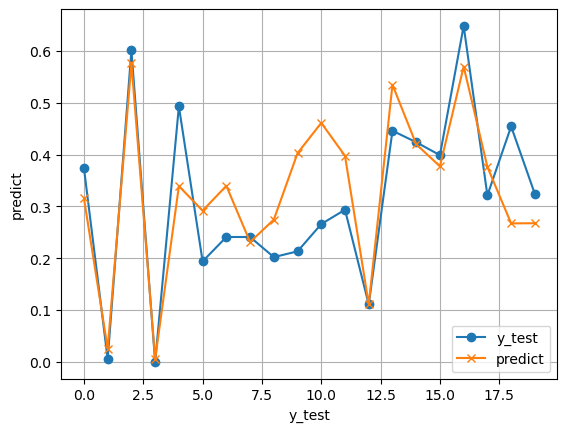

In [41]:
plt.plot(comparison["y_test"].values[:20], label='y_test', marker='o')
plt.plot(comparison["predict"].values[:20], label='predict', marker='x')
plt.xlabel("y_test")
plt.ylabel("predict")
plt.legend()
plt.grid(True)
plt.show()

The Remaining Useful Life (RUL) model predicts how long each engine or component will continue to operate before failure.
This helps maintenance planners and decision-makers to take proactive action rather than waiting for breakdowns.